In [1]:
#  Compatibility imports
from scipy.io import wavfile
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

import tensorflow as tf
import scipy.io.wavfile as wav
import numpy as np

from six.moves import xrange as range

try:
    from tensorflow.python.ops import ctc_ops
except ImportError:
    from tensorflow.contrib.ctc import ctc_ops

try:
    from python_speech_features import mfcc
except ImportError:
    print("Failed to import python_speech_features.\n Try pip install python_speech_features.")
    raise ImportError

from utils import maybe_download as maybe_download
from utils import sparse_tuple_from as sparse_tuple_from

In [2]:
import os
import glob
import scipy.io.wavfile as wav
from unicodedata import normalize

In [3]:
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII','ignore').decode('ASCII')

In [4]:
# Constants
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space

In [5]:
# Some configs
num_features = 13
# Accounting the 0th indice +  space + blank label = 28 characters
num_classes = ord('z') - ord('a') + 1 + 1 + 1

# Hyper-parameters
num_epochs = 3
num_hidden = 50
num_layers = 1
batch_size = 1
initial_learning_rate = 1e-2
momentum = 0.9

num_examples = 1
num_batches_per_epoch = int(num_examples/batch_size)
num_arquivos = 100

In [6]:
def audioTexto(qtde):
    arquivos_e_diretorios = os.listdir('data/') #lista de arquivos e diretórios
    diretorios = []
    #pega somente os diretórios e coloca na lista de diretorios
    for arquivo in arquivos_e_diretorios:
            if arquivo.find('.tgz') == -1:
                diretorios.append(arquivo)   
    
    #pega somente os arquivos wav e coloca na lista de waves
    waves = []    
    for diretorio in diretorios:
        for file in glob.glob('data/' + diretorio+'/wav/*.wav'):
            waves.append(file)
    lista_audio = []
    lista_texto = []
    lista_waves = []
    lista_audio_texto = lista_audio, lista_texto    
    for w in waves[:qtde]:
        txt = w[:-11]+'etc/prompts-original' #pega o nome e retira os últimos 11 digitos e completa do /etc até o txt
        numero = w[-7:-4]  #pega somente o número do arquivo de áudio
        try:
            for line in open(txt):
                if(line.strip().startswith(numero)): #pega o texto a partir do número do audio                    
                    lista_audio.append(w)
                    _, arq_audio = wav.read(w)
                    lista_waves.append(arq_audio)
                    lista_texto.append(remover_acentos(line[4:-1]).lower().replace('.','').replace('?',''))                   
        except IOError as e:
            print("Não encontrou o arquivo:" + w)  
    return lista_audio, lista_texto, lista_waves

In [7]:
t = audioTexto(num_arquivos)

In [8]:
path, texto, audio = t

In [9]:
audio = np.concatenate(audio)

In [10]:
texto

['de quem e a caneta ',
 'eu e pedro andamos a cavalo nos sabados ',
 'por que voce comprou essa revista ',
 'quando e o seu aniversario ',
 'eu pago a conta e voces deixam a gorjeta ',
 'pode me dar o seu endereco ',
 'nos nao mentimos nunca ',
 'no casamento havia muitas flores ',
 'na festa, todo mundo estava muito contente ',
 'esta chovendo e eu esqueci o meu guarda-chuva ',
 'meu pai tem que fazer escala no rio de janeiro ',
 'eu e pedro andamos a cavalo nos sabados ',
 'por que voce comprou essa revista ',
 'eu pago a conta e voces deixam a gorjeta ',
 'quando eu era crianca, nao gostava de morangos ',
 'nos nao mentimos nunca ',
 'onde e o aeroporto ',
 'na festa, todo mundo estava muito contente ',
 'sao duas e meia da tarde ',
 'esta chovendo e eu esqueci o meu guarda-chuva ',
 'de quem e a caneta ',
 'eu e pedro andamos a cavalo nos sabados ',
 'por que voce comprou essa revista ',
 'quando e o seu aniversario ',
 'eu pago a conta e voces deixam a gorjeta ',
 'pode me dar o 

In [11]:
fs = 16000

In [12]:
audio.shape

(2505000,)

In [13]:
from pylab import*

In [14]:
timeArray = arange(0, len(audio), 1)

In [15]:
plot(timeArray, audio, color='r')
ylabel('Amplitude')
xlabel('Time (ms)')

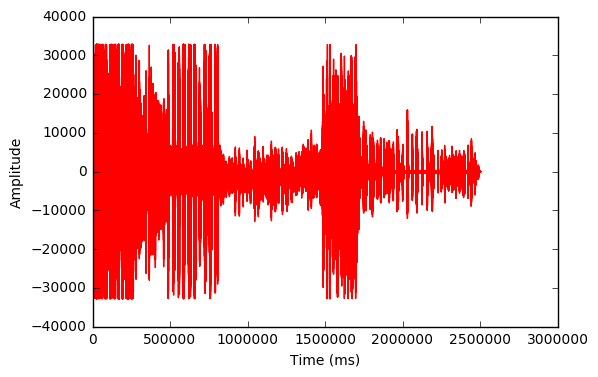

In [16]:
show()

In [17]:
inputs = mfcc(audio, samplerate=fs)

In [18]:
inputs.shape

(15655, 13)

In [19]:
# Tranform in 3D array
train_inputs = np.asarray(inputs[np.newaxis, :])

In [20]:
train_inputs.shape

(1, 15655, 13)

In [21]:
train_inputs = (train_inputs - np.mean(train_inputs))/np.std(train_inputs)

In [22]:
train_seq_len = [train_inputs.shape[1]]

In [23]:
#original = ' '.join(s.strip().lower().split(' ')[2:]).replace('.', '')
#original = 'Aquela mulher e portuguesa'.lower()
#original = 'Aquela mulher e portuguesa Vou cumprir'.lower()
#original = 'Aquela mulher e portuguesa Vou cumprir Vamos comprar um carro que funciona Os funcionarios chegam tarde todos os dias'.lower()
original = ''.join(texto)

In [24]:
targets = original.replace(' ', '  ').replace(',','').replace('-','')

In [25]:
targets

'de  quem  e  a  caneta  eu  e  pedro  andamos  a  cavalo  nos  sabados  por  que  voce  comprou  essa  revista  quando  e  o  seu  aniversario  eu  pago  a  conta  e  voces  deixam  a  gorjeta  pode  me  dar  o  seu  endereco  nos  nao  mentimos  nunca  no  casamento  havia  muitas  flores  na  festa  todo  mundo  estava  muito  contente  esta  chovendo  e  eu  esqueci  o  meu  guardachuva  meu  pai  tem  que  fazer  escala  no  rio  de  janeiro  eu  e  pedro  andamos  a  cavalo  nos  sabados  por  que  voce  comprou  essa  revista  eu  pago  a  conta  e  voces  deixam  a  gorjeta  quando  eu  era  crianca  nao  gostava  de  morangos  nos  nao  mentimos  nunca  onde  e  o  aeroporto  na  festa  todo  mundo  estava  muito  contente  sao  duas  e  meia  da  tarde  esta  chovendo  e  eu  esqueci  o  meu  guardachuva  de  quem  e  a  caneta  eu  e  pedro  andamos  a  cavalo  nos  sabados  por  que  voce  comprou  essa  revista  quando  e  o  seu  aniversario  eu  pago  a  conta  e  voces 

In [26]:
targets = targets.split(' ')

In [27]:
# Adding blank label
targets = np.hstack([SPACE_TOKEN if x == '' else list(x) for x in targets])

In [28]:
# Transform char into index
targets = np.asarray([SPACE_INDEX if x == SPACE_TOKEN else ord(x) - FIRST_INDEX
                      for x in targets])

In [29]:
# Creating sparse representation to feed the placeholder
train_targets = sparse_tuple_from([targets])

In [30]:
# We don't have a validation dataset :(
val_inputs, val_targets, val_seq_len = train_inputs, train_targets, train_seq_len

In [31]:
val_inputs.shape

(1, 15655, 13)

In [32]:
# THE MAIN CODE!

graph = tf.Graph()

In [33]:
# THE MAIN CODE!

graph = tf.Graph()
with graph.as_default():
    # e.g: log filter bank or MFCC features
    # Has size [batch_size, max_stepsize, num_features], but the
    # batch_size and max_stepsize can vary along each step
    inputs = tf.placeholder(tf.float32, [None, None, num_features])

    # Here we use sparse_placeholder that will generate a
    # SparseTensor required by ctc_loss op.
    targets = tf.sparse_placeholder(tf.int32)

    # 1d array of size [batch_size]
    seq_len = tf.placeholder(tf.int32, [None])

    # Defining the cell
    # Can be:
    #   tf.nn.rnn_cell.RNNCell
    #   tf.nn.rnn_cell.GRUCell
    cell = tf.nn.rnn_cell.LSTMCell(num_hidden, state_is_tuple=True)

    # Stacking rnn cells
    stack = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers,
                                        state_is_tuple=True)

    # The second output is the last state and we will no use that
    outputs, _ = tf.nn.dynamic_rnn(stack, inputs, seq_len, dtype=tf.float32)

    shape = tf.shape(inputs)
    batch_s, max_timesteps = shape[0], shape[1]

    # Reshaping to apply the same weights over the timesteps
    outputs = tf.reshape(outputs, [-1, num_hidden])

    # Truncated normal with mean 0 and stdev=0.1
    # Tip: Try another initialization
    # see https://www.tensorflow.org/versions/r0.9/api_docs/python/contrib.layers.html#initializers
    W = tf.Variable(tf.truncated_normal([num_hidden,
                                         num_classes],
                                        stddev=0.1))
    # Zero initialization
    # Tip: Is tf.zeros_initializer the same?
    b = tf.Variable(tf.constant(0., shape=[num_classes]))

    # Doing the affine projection
    logits = tf.matmul(outputs, W) + b

    # Reshaping back to the original shape
    logits = tf.reshape(logits, [batch_s, -1, num_classes])

    # Time major
    logits = tf.transpose(logits, (1, 0, 2))

    loss = ctc_ops.ctc_loss(logits, targets, seq_len)
    cost = tf.reduce_mean(loss)

    optimizer = tf.train.MomentumOptimizer(initial_learning_rate,
                                           0.9).minimize(cost)

    # Option 2: tf.contrib.ctc.ctc_beam_search_decoder
    # (it's slower but you'll get better results)
    decoded, log_prob = ctc_ops.ctc_greedy_decoder(logits, seq_len)

    # Inaccuracy: label error rate
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),
                                          targets))

In [34]:
with tf.Session(graph=graph) as session:
    # Initializate the weights and biases
    tf.initialize_all_variables().run()


    for curr_epoch in range(num_epochs):
        train_cost = train_ler = 0
        start = time.time()

        for batch in range(num_batches_per_epoch):

            feed = {inputs: train_inputs,
                    targets: train_targets,
                    seq_len: train_seq_len}            
            batch_cost, _ = session.run([cost, optimizer], feed)
            train_cost += batch_cost*batch_size
            train_ler += session.run(ler, feed_dict=feed)*batch_size

        train_cost /= num_examples
        train_ler /= num_examples

        val_feed = {inputs: val_inputs,
                    targets: val_targets,
                    seq_len: val_seq_len}

        val_cost, val_ler = session.run([cost, ler], feed_dict=val_feed)

        log = "Epoch {}/{}, train_cost = {:.3f}, train_ler = {:.3f}, val_cost = {:.3f}, val_ler = {:.3f}, time = {:.3f}"
        print(log.format(curr_epoch+1, num_epochs, train_cost, train_ler,
                         val_cost, val_ler, time.time() - start))
    # Decoding
    d = session.run(decoded[0], feed_dict=feed)
    str_decoded = ''.join([chr(x) for x in np.asarray(d[1]) + FIRST_INDEX])
    # Replacing blank label to none
    str_decoded = str_decoded.replace(chr(ord('z') + 1), '')
    # Replacing space label to space
    str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')

    print('Original:\n%s' % original)
    print('Decoded:\n%s' % str_decoded)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 1/3, train_cost = 39262.406, train_ler = 1.000, val_cost = inf, val_ler = 1.000, time = 99.374
Epoch 2/3, train_cost = inf, train_ler = 0.849, val_cost = inf, val_ler = 0.849, time = 50.939
Epoch 3/3, train_cost = inf, train_ler = 0.895, val_cost = inf, val_ler = 0.895, time = 73.369
Original:
de quem e a caneta eu e pedro andamos a cavalo nos sabados por que voce comprou essa revista quando e o seu aniversario eu pago a conta e voces deixam a gorjeta pode me dar o seu endereco nos nao mentimos nunca no casamento havia muitas flores na festa, todo mundo estava muito contente esta chovendo e eu esqueci o meu guarda-chuva meu pai tem que fazer escala no rio de janeiro eu e pedro andamos a cavalo nos sabados por que voce comprou essa revista eu pago a conta e voces deixam a gorjeta quando eu era crianca, nao gostava de morangos nos nao mentimos nunca onde e o aeroporto na festa, todo mundo estava muito content